# Машинное обучение
## Лабораторная работа №2

Выполнил студент группы 15-В-2   
Брызгалов Роман

Вариант №62

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (StratifiedKFold, 
                                     train_test_split,
                                     cross_val_score)
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

**Набор данных описывает характеристики животных - молюсков. Научим классификатор предсказывать их пол по заданным параметрам**

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|sex|пол|категории: F - женский, M - мужской|
|lenght|длина|вещественный|
|diameter|диаметер| вещественный|
|height|высота|вещественный|
|whole weight|общий вес|вещественный|
|shucked weight|вес тела|вещественный|
|viscera weight|вес высушенного тела|вещественный|
|shell weight|вес панциря|вещественный|
|rings|число колец|целочисленный|

In [2]:
fname = 'abalone.data.txt'
header = ['sex', 'lenght', 'diameter', 
          'height', 'whole weight', 'shucked weight',
         'vicsera weight', 'shell weight', 'rings']
df = pd.read_csv(fname, names=header)
df.head()

,sex,lenght,diameter,height,whole weight,shucked weight,vicsera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20


In [3]:
print('dataset size', df.shape)
df.count()

dataset size (2835, 9)


sex               2835
lenght            2835
diameter          2835
height            2835
whole weight      2835
shucked weight    2835
vicsera weight    2835
shell weight      2835
rings             2835
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [4]:
df = df.drop_duplicates()
print('dataset size', df.shape)
df.count()

dataset size (2835, 9)


sex               2835
lenght            2835
diameter          2835
height            2835
whole weight      2835
shucked weight    2835
vicsera weight    2835
shell weight      2835
rings             2835
dtype: int64

### 3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

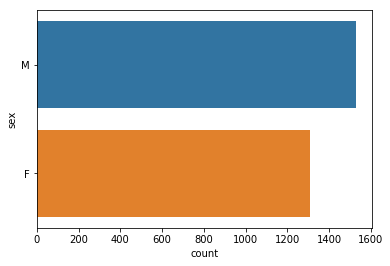

In [5]:
sns.countplot(data=df, y='sex')
plt.show()

Размеры выборок практически равны, поэтому будем считать, что данные сбалансированы. Подойдет любая метрика.

### 4)  Выполните масштабирование количественных признаков

In [6]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['lenght', 'diameter', 'height', 'whole weight', 'shucked weight', 'vicsera weight', 'shell weight', 'rings']
categorial:  ['sex']


In [7]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,sex,lenght,diameter,height,whole weight,shucked weight,vicsera weight,shell weight,rings
0,M,0.454545,0.472222,0.071749,0.177402,0.147148,0.129458,0.145,0.461538
1,M,0.295455,0.287037,0.067265,0.074733,0.062774,0.060106,0.065,0.153846
2,F,0.568182,0.574074,0.107623,0.235409,0.168748,0.182959,0.205,0.230769
3,M,0.431818,0.472222,0.098655,0.178114,0.141073,0.146631,0.150,0.269231
4,F,0.568182,0.564815,0.121076,0.271174,0.155586,0.182959,0.325,0.653846


### 5) Выполните замену категориальных признаков

В наборе находится только однин категориальный признак, который имеет всего два уникальных значения, заменим их на 0 и 1

In [8]:
df = df.replace(to_replace=['M', 'F'], value=[1, 0])
df.head()

,sex,lenght,diameter,height,whole weight,shucked weight,vicsera weight,shell weight,rings
0,1,0.454545,0.472222,0.071749,0.177402,0.147148,0.129458,0.145,0.461538
1,1,0.295455,0.287037,0.067265,0.074733,0.062774,0.060106,0.065,0.153846
2,0,0.568182,0.574074,0.107623,0.235409,0.168748,0.182959,0.205,0.230769
3,1,0.431818,0.472222,0.098655,0.178114,0.141073,0.146631,0.150,0.269231
4,0,0.568182,0.564815,0.121076,0.271174,0.155586,0.182959,0.325,0.653846


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

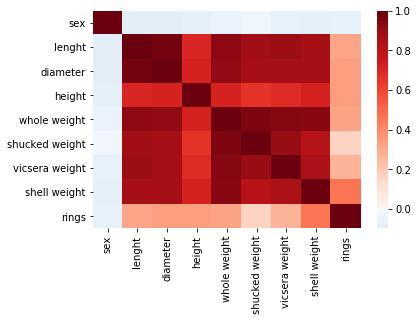

In [9]:
df_corr = df.corr()
colors = sns.color_palette("Blues_r", n_colors=100)
colors += sns.color_palette("Reds", n_colors=100)
sns.heatmap(df_corr, cmap=colors, center=0)
plt.show()

### 7)   Заполните пропущенные значения в данных

In [10]:
print('dataset size', df.shape)
df.count()

dataset size (2835, 9)


sex               2835
lenght            2835
diameter          2835
height            2835
whole weight      2835
shucked weight    2835
vicsera weight    2835
shell weight      2835
rings             2835
dtype: int64

### 8)	Решите поставленную задачу классификации в соответствии с заданием
- классификатор K ближайших соседей
- логический классификатор (бинарное решающее дерево)

In [11]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('sex', axis=1), df['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print('size of train set: ', X_train.shape)
print('size of test set: ', X_test.shape)

size of train set:  (1984, 8)
size of test set:  (851, 8)


** Ближайшие соседи  - подбор параметров**

In [18]:
knn = KNeighborsClassifier()
params = {'n_neighbors': list(range(1, 50))}
knn_grid = GridSearchCV(knn, params)
knn_grid.fit(X_train, y_train)
best_num = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_

print('best train score: ', best_score,
      '\t at neighbors number: ', best_num)

rnc = KNeighborsClassifier(n_neighbors=best_num)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score:  0.5418346774193549 	 at neighbors number:  29
test score:  0.539365452409


** Решающее дерево - подбор параметров **

In [16]:
# Дерево
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,12)), 'max_features': list(range(1,9))}
dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X_train, y_train)
best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_

print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X_train, y_train)
best_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', best_score)

best train score: 0.5609879032258065 	 at features number: 5 	 at depth: 9
test score:  0.52526439483


** Графики **

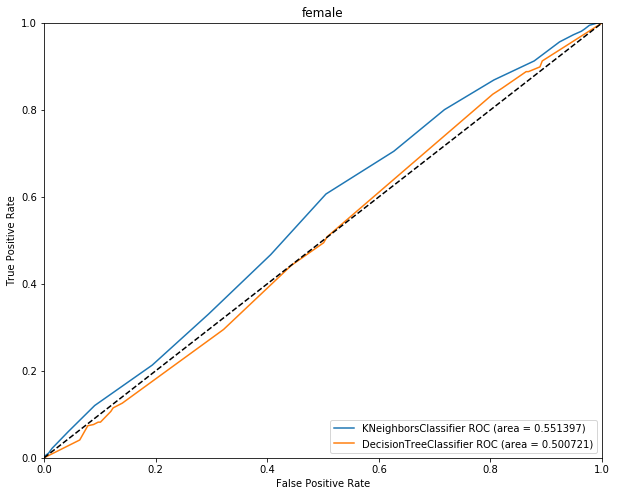

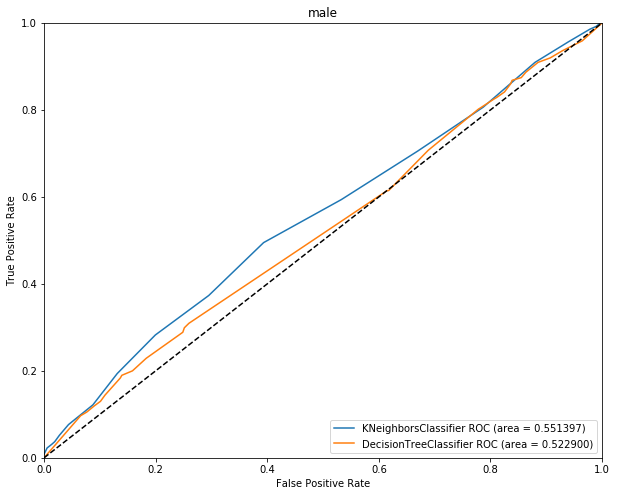

In [23]:
plt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier ( n_neighbors =best_num)
probas_knn0 = knn.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_knn0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 

# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc0 = dtc.fit(X_train, y_train).predict_proba (X_test)
tpr, fpr, thresholds = roc_curve(y_test, probas_dtc0[:,0])
roc_auc  = auc (fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('female')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
knn = KNeighborsClassifier( n_neighbors = best_num)
probas_knn1 = knn.fit(X_train, y_train).predict_proba (X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_knn1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('KNeighborsClassifier', roc_auc)) 
# решающее дерево
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
probas_dtc1 = dtc.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_dtc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))   
# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('male')
plt.show()

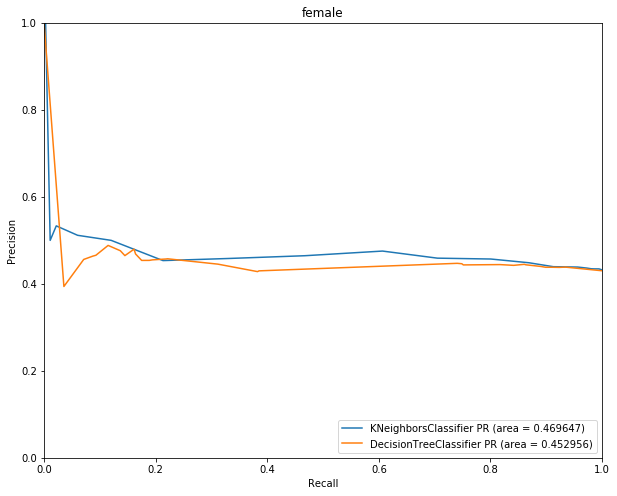

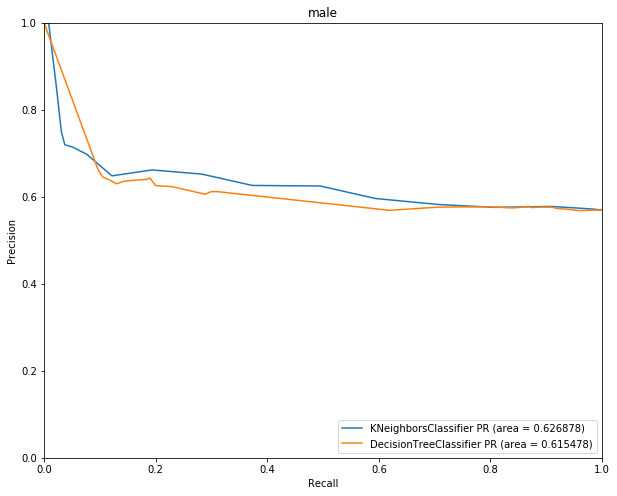

In [25]:
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_knn1[:,0])
aps_knn1 = average_precision_score(y_test_invers,probas_knn1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn1)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_dtc1[:,0])
aps_dtc1 = average_precision_score(y_test_invers,probas_dtc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('female')
plt.show()


plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_knn0[:,1])
aps_knn0 = average_precision_score(y_test,probas_knn0[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('KNeighborsClassifier', aps_knn0)) 
# решающее дерево
precision, recall, thresholds = precision_recall_curve(y_test, probas_dtc1[:,1])
aps_dtc1 = average_precision_score(y_test,probas_dtc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('male')
plt.show()

**Вывод:** классификатор не удалось научить распознавать пол молюсков, так как заданные параметры сильно  коррелируют между друг другом, причем не влияя на классифицируемый параметр